In [6]:
import os

import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root_scalar

from pydd.analysis import (
    calculate_SNR_cut,
    calculate_match_unnormd,
    get_match_pads,
    loglikelihood_cut,
    loglikelihood_fft,
)
from pydd.binary import *
from pydd.noise import *  # type: ignore

Array = jnp.ndarray

- Get $\Delta\tilde{t}_c$ out of FFT-maximized match
- Verify this actually maximizes the match
- Use this value and the correct frequency window for the template to recalculate the match
- Do this for a bunch of posterior samples to see how much it changes the likelihood

Simpler ideas that don't require $\Delta\tilde{t}_c$:
* Compute dephasing for posterior samples
* 

In [7]:
ns = jnp.load(
    os.path.join(
        "..",
        "scripts",
        "ns",
        "rho_6T=0.5345_gamma_s=2.25.pkl",
    ),
    allow_pickle=True,
)
ps = jnp.exp(ns.logwt - ns.logwt.max())
ps = ps / jnp.sum(ps)


def resample_posterior(key, Phi_c=0.0, tT_c=0.0, dL=100e6 * PC) -> Array:
    theta = random.choice(key, a=ns.samples, shape=(1,), p=ps)[0]
    rho_6 = theta[1] * 1e16 * MSUN / PC**3
    M_chirp = theta[2] * MSUN
    q = 10 ** theta[3]
    m_1 = get_m_1(M_chirp, q)
    dd = DynamicDress(theta[0], rho_6, M_chirp, q, Phi_c, tT_c, dL, get_f_isco(m_1))
    return theta, dd


def replace_tT_c(dd, tT_c) -> DynamicDress:
    return DynamicDress(
        dd.gamma_s, dd.rho_6, dd.M_chirp, dd.q, dd.Phi_c, tT_c, dd.dL, dd.f_c
    )

In [47]:
# Setup
GAMMA_S_PBH = jnp.array(9 / 4)
S_n, F_RANGE_NOISE = S_n_LISA, f_range_LISA
M_1 = jnp.array(1e3 * MSUN)
M_2 = jnp.array(1.4 * MSUN)
M_CHIRP = get_M_chirp(M_1, M_2)
Q = M_2 / M_1
GAMMA_S = GAMMA_S_PBH
RHO_6 = 0.5345e16 * MSUN / PC ** 3
TT_C = jnp.array(0.0)
F_C = get_f_isco(M_1)
PHI_C = jnp.array(0.0)
_DD_D = DynamicDress(
    GAMMA_S,
    RHO_6,
    get_M_chirp(M_1, M_2),
    M_2 / M_1,
    PHI_C,
    tT_c=TT_C,
    dL=jnp.array(100e6 * PC),
    f_c=get_f_isco(M_1),
)

# Get f_range
T_OBS = 5 * YR
F_RANGE_D = get_f_range(_DD_D, T_OBS)

# Get frequency grid close to the frequency range
DF = 4.375e-5
F_RANGE_D = (jnp.ceil(F_RANGE_D[0] / DF) * DF, jnp.floor(F_RANGE_D[1] / DF) * DF)
FS = jnp.linspace(*F_RANGE_D, int((F_RANGE_D[1] - F_RANGE_D[0]) / DF) + 1)
PAD_LOW, PAD_HIGH = get_match_pads(FS)

# Get dL
SNR_THRESH = 12.0
_fn = jax.jit(
    lambda dL: calculate_SNR_cut(
        DynamicDress(
            _DD_D.gamma_s,
            _DD_D.rho_6,
            _DD_D.M_chirp,
            _DD_D.q,
            _DD_D.Phi_c,
            _DD_D.tT_c,
            dL,
            _DD_D.f_c,
        ),
        F_RANGE_D,
        FS,
        S_n,
    )
)
res = root_scalar(
    lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC)
)
assert res.converged
DL = res.root

# Signal system
DD_D = DynamicDress(
    _DD_D.gamma_s,
    _DD_D.rho_6,
    _DD_D.M_chirp,
    _DD_D.q,
    _DD_D.Phi_c,
    _DD_D.tT_c,
    DL,
    _DD_D.f_c,
)

In [58]:
key = random.PRNGKey(64)
thetas = []
dNs = []
for _ in range(100):
    key, subkey = random.split(key)
    theta, dd_h = resample_posterior(subkey)
    thetas.append(theta)
    N_d = (Phi_to_c(F_RANGE_D[0], DD_D) - Phi_to_c(F_RANGE_D[1], DD_D)) / (2 * pi)
    N_h = (Phi_to_c(F_RANGE_D[0], dd_h) - Phi_to_c(F_RANGE_D[1], dd_h)) / (2 * pi)
    dNs.append(N_h - N_d)

thetas = jnp.array(thetas)
dNs = jnp.array(dNs)

(array([ 2.,  1.,  8., 14., 19., 18., 20., 11.,  3.,  4.]),
 array([-6.00835804, -5.02559882, -4.04283959, -3.06008037, -2.07732115,
        -1.09456192, -0.1118027 ,  0.87095652,  1.85371575,  2.83647497,
         3.81923419]),
 <BarContainer object of 10 artists>)

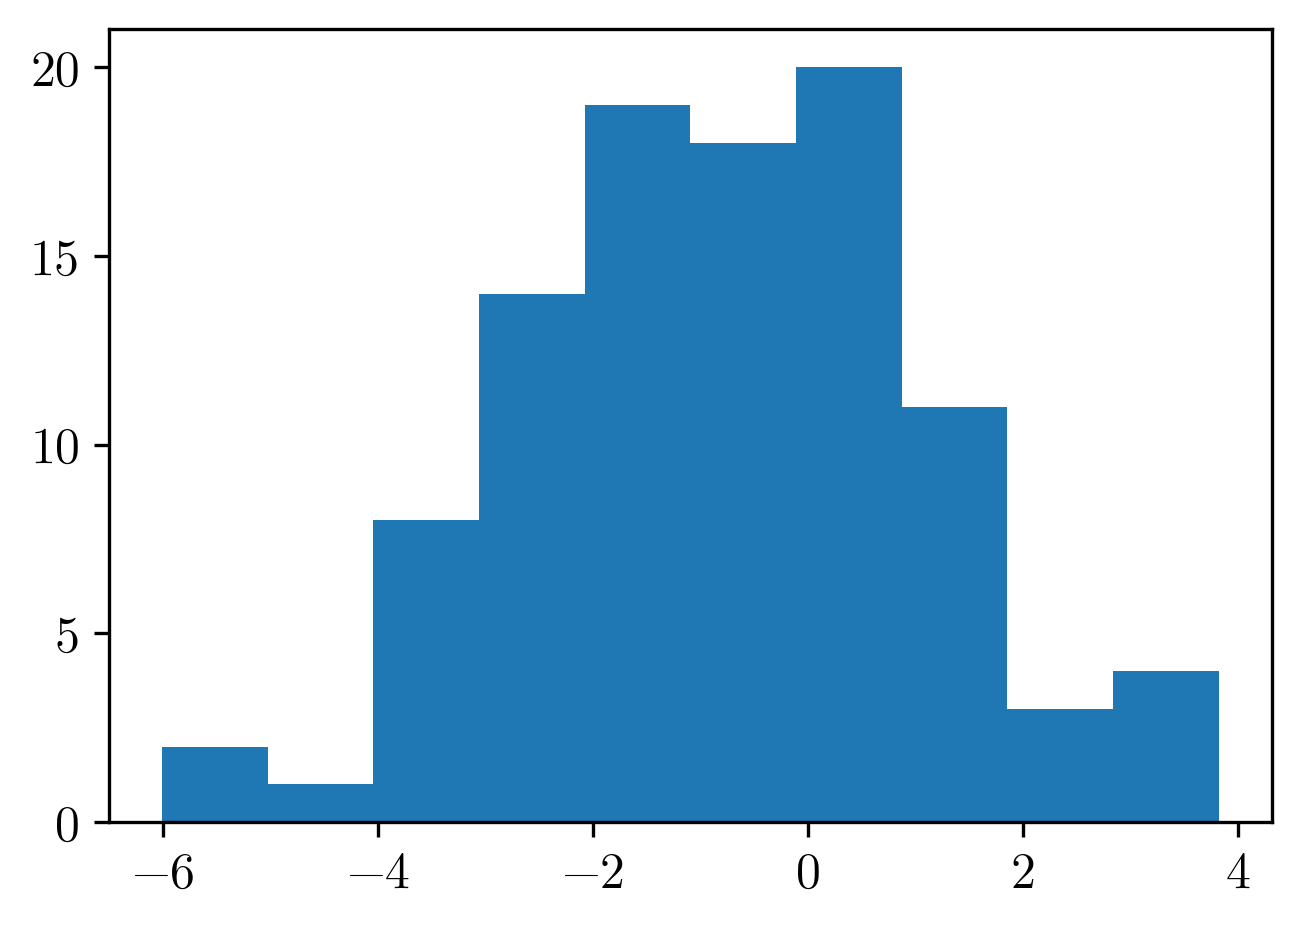

In [59]:
plt.hist(dNs)

In [76]:
def get_match_un_fft(
    params_h: Binary, params_d: Binary, fs, pad_low, pad_high, S_n=S_n_LISA
):
    """
    Inner product of waveforms, maximized over Phi_c by taking absolute value
    and t_c using the fast Fourier transform.
    """
    df = fs[1] - fs[0]
    wf_h = amp(fs, params_h) * jnp.exp(1j * Psi(fs, params_h))
    wf_d = amp(fs, params_d) * jnp.exp(1j * Psi(fs, params_d))
    Sns = S_n(fs)

    # Use IFFT trick to maximize over t_c. Ref: Maggiore's book, eq. 7.171.
    integrand = 4 * wf_h.conj() * wf_d / Sns * df
    integrand_padded = jnp.concatenate((pad_low, integrand, pad_high))

    overlap_tc = jnp.abs(len(integrand_padded) * jnp.fft.ifft(integrand_padded))
    return overlap_tc#, tT_c

#     df = fs[1] - fs[0]
#     n_t = 2 * (len(FS) - 1)
#     t_temp = jnp.linspace(-1, 1, n_t) / df
#     overlap_tc = jnp.abs(len(integrand_padded) * jnp.fft.irfft(integrand_padded))
#     idx = overlap_tc.argmax()
#     tT_c = t_temp[idx]
#     return overlap_tc[idx], tT_c

In [122]:
key, subkey = random.split(key)
dd_h = resample_posterior(subkey)[1]
overlap_tc = get_match_un_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n)
overlap_tc.argmax().item(), len(overlap_tc)

(61, 201004)

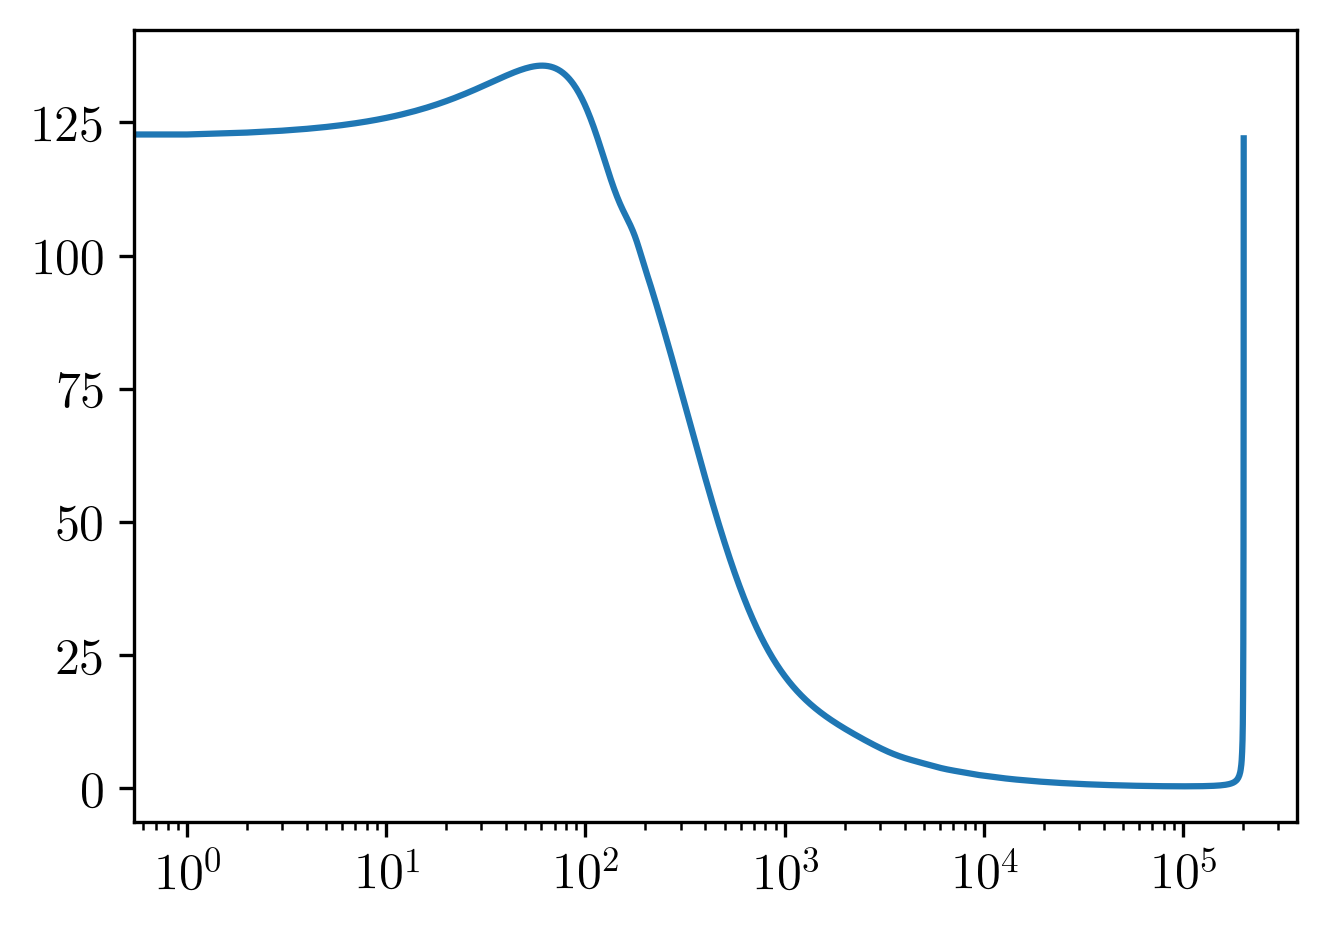

In [125]:
plt.plot(overlap_tc)
plt.xscale("log")

DeviceArray(1.31771847, dtype=float64)

In [134]:
key = jrandom.PRNGKey(64)
key, subkey = jrandom.split(key)
dd_h = resample_posterior(subkey)
match_fft, tT_c_fft = get_match_un_fft(dd_h, DD_D, FS, PAD_LOW, PAD_HIGH, S_n)
dd_h = replace_tT_c(dd_h, tT_c_fft)
print(match_fft, calculate_match_unnormd(dd_h, DD_D, FS, S_n))

109.42857990616895 16.600431688573607


In [ ]:
110.20259016612529  # i fft
109.42857990616895  # irfft

In [115]:
tT_cs = jnp.linspace(-14, -9, 40)
matches = []
for tT_c in tT_cs:
    dd_h = replace_tT_c(dd_h, tT_c)
    matches.append(calculate_match_unnormd(dd_h, DD_D, FS, S_n))

matches = jnp.array(matches)

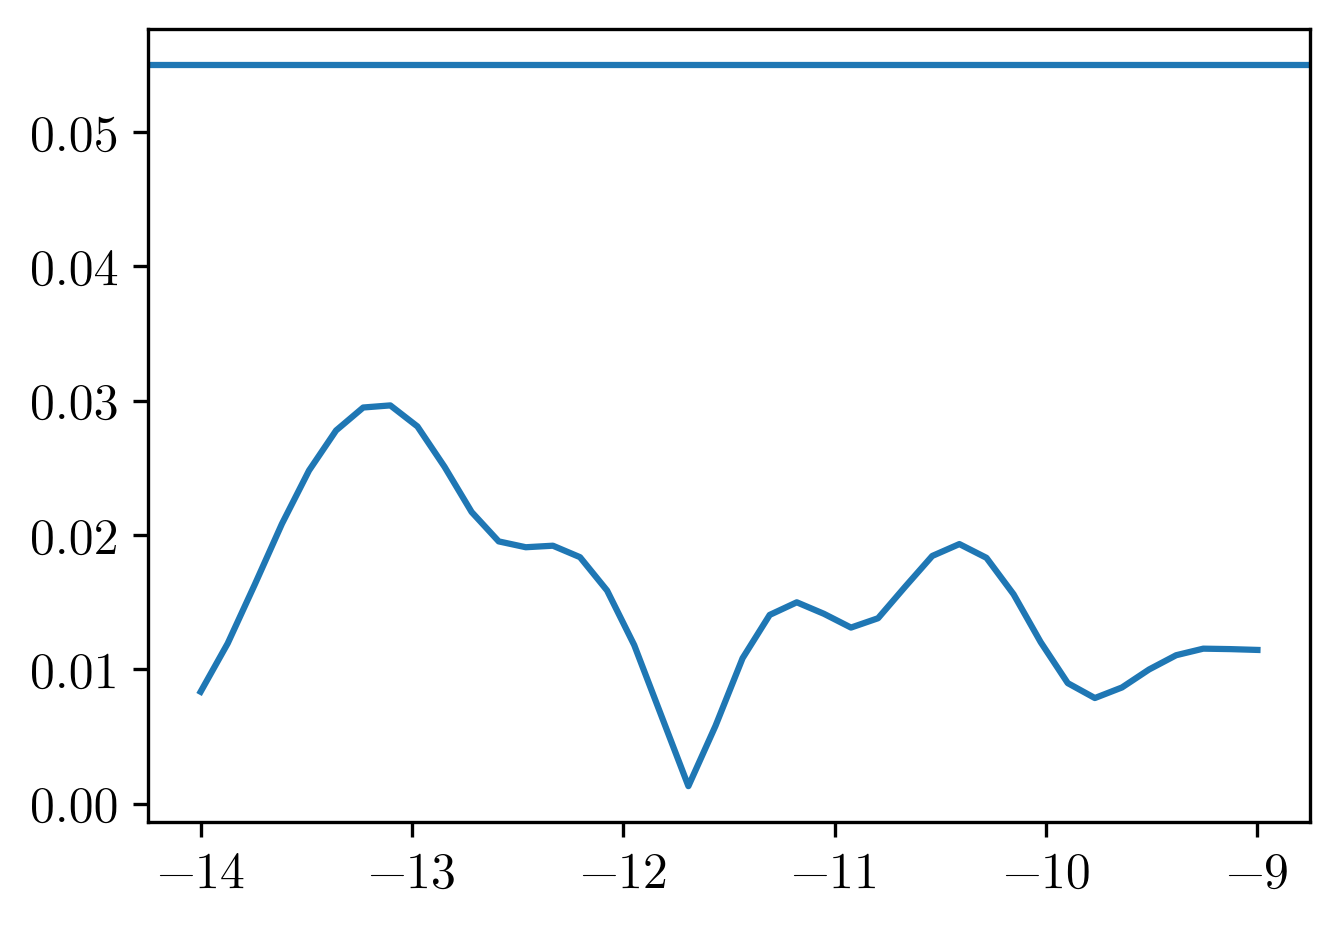

In [116]:
plt.plot(tT_cs, matches)
# plt.axvline(tT_c_fft)
plt.axhline(match_fft)